# Recomendación de película

El conjunto de datos que nos ocupa contiene registros de películas vistas por los usuarios y sus calificaciones. Su trabajo es extraer las relaciones de las películas vistas por un usuario y recomendar películas a un usuario en función de las películas vistas anteriormente. Esto es lo mismo que YouTube te recomienda videos diciendo que las personas que vieron este video también vieron este, o tal vez Netflix o Amazon Prime te recomiendan otras películas o series según tu historial de visualización y de otras personas que han visto las mismas películas que tú.

Comencemos a crear un sistema de recomendación para películas.

In [2]:
# Importar librerías
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
# Cargar los datos
RUTA_GLOBAL = './Data/'
ratings_df = pd.read_csv(f'{RUTA_GLOBAL}/ratings_small.csv')
movies_df = pd.read_csv(f'{RUTA_GLOBAL}/movies_metadata.csv', low_memory=False)

### 1. Limpieza de `ratings_df`

In [4]:
# Filtrar columnas necesarias: userId, movieId y rating
ratings_df = ratings_df[['userId', 'movieId', 'rating']]

In [5]:
# Convertir las calificaciones a valores binarios (0 o 1)
# Si la calificación es mayor o igual a 3.5, se considera que le gustó la película
ratings_df['rating'] = np.where(ratings_df['rating'] >= 3.5, 1, 0)

In [6]:
# Asegurarse de que todos los valores sean enteros
ratings_df = ratings_df.astype({'userId': 'int', 'movieId': 'int', 'rating': 'int'})

# Verificar la limpieza de datos en ratings_df
print(ratings_df.head())

   userId  movieId  rating
0       1       31       0
1       1     1029       0
2       1     1061       0
3       1     1129       0
4       1     1172       1


### 2. Limpieza de `movies_df`

In [7]:
# Mantener columnas relevantes: id (movieId), title, y genres
movies_df = movies_df[['id', 'title', 'genres']]

In [8]:
# Convertir 'id' a int para emparejar con movieId en ratings_df
movies_df = movies_df[movies_df['id'].str.isdigit()]  # Filtrar solo IDs numéricos
movies_df['id'] = movies_df['id'].astype(int)

In [9]:
# Verificar la limpieza de datos en movies_df
movies_df.head()

,id,title,genres
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]"


### 3. Unir datasets `ratings_df` y `movies_df`

In [10]:
# Combinar ambos DataFrames por la clave `movieId` y `id`
merged_df = pd.merge(ratings_df, movies_df, left_on='movieId', right_on='id')

In [11]:
# Eliminar columnas innecesarias después de la unión
merged_df = merged_df[['userId', 'movieId', 'title', 'rating']]

# Verificar el conjunto de datos combinado
merged_df.head()

,userId,movieId,title,rating
0,1,1371,Rocky III,0
1,1,1405,Greed,0
2,1,2105,American Pie,1
3,1,2193,My Tutor,0
4,1,2294,Jay and Silent Bob Strike Back,0


### 4. Crear una matriz de usuario-película

In [12]:
# Crear una tabla cruzada donde las filas son usuarios y las columnas son películas

# Los valores son las calificaciones binarias (0 o 1)
user_movie_matrix = merged_df.pivot_table(
    index='userId', 
    columns='title', 
    values='rating', 
    fill_value=0
)

# Verificar la matriz
user_movie_matrix.head()

title,!Women Art Revolution,'Gator Bait,'Twas the Night Before Christmas,...And God Created Woman,00 Schneider - Jagd auf Nihil Baxter,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,...,Zodiac,Zombie Flesh Eaters,Zombie Holocaust,Zozo,eXistenZ,xXx,¡Three Amigos!,À nos amours,Ödipussi,Şaban Oğlu Şaban
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5. Aplicar un umbral de soporte mínimo

In [13]:
# Calcular el soporte de cada película (el porcentaje de usuarios que la han visto y les gustó)
movie_support = user_movie_matrix.sum(axis=0) / user_movie_matrix.shape[0]

# Establecer un umbral para el soporte mínimo, por ejemplo, 0.05 (al menos el 5% de los usuarios)
min_support_threshold = 0.05
popular_movies = movie_support[movie_support >= min_support_threshold].index

# Filtrar la matriz de usuario-película para conservar solo las películas con suficiente soporte
filtered_user_movie_matrix = user_movie_matrix[popular_movies]

# Verificar la matriz filtrada
filtered_user_movie_matrix.head()

title,2001: A Space Odyssey,48 Hrs.,5 Card Stud,A Brief History of Time,A Clockwork Orange,A Nightmare on Elm Street,A River Runs Through It,A Time to Kill,Aguirre: The Wrath of God,Aliens vs Predator: Requiem,...,Under the Sand,Wag the Dog,Waiter,While You Were Sleeping,Who Killed Bambi?,Will Penny,Windows on Monday,X-Men Origins: Wolverine,Young and Innocent,Zatoichi
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# Guardar los datos limpios para el entrenamiento del modelo Apriori
filtered_user_movie_matrix.to_csv(f'{RUTA_GLOBAL}/filtered_user_movie_matrix.csv', index=True)

# Entrenar el modelo

El modelo a priori calcula la probabilidad para determinar la probabilidad de que un usuario vea la película M2 si ya ha visto una película M1. Lo hace calculando el apoyo, la confianza y el impulso para diferentes combinaciones de películas.

El soporte de una película M1 es como la probabilidad de que los usuarios vean la película M1. Se da como -

<center>

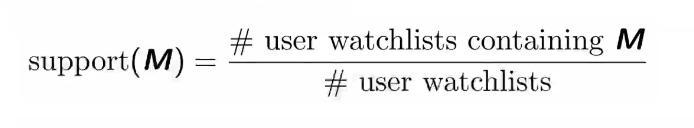

</center>

El soporte calcula, del total de usuarios, cuánto porcentaje de usuarios tienen la película M1 en su lista de seguimiento.

*Nota: Aquí M1 puede ser una sola película o un grupo de películas.*

La confianza en una película se calcula entre el total de usuarios que han visto la película M1 y cuántos también han visto la película M2. Se denota como Confianza (M1 -> M2) y se calcula como -

<center>

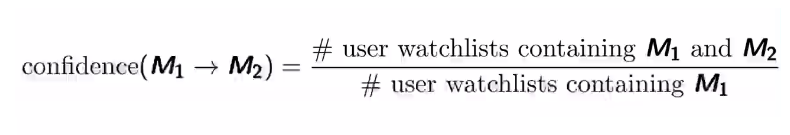
</center>

La elevación es la relación entre confianza y apoyo.
<center>

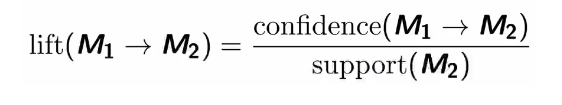
</center>

A partir de la definición de soporte, sabes que Soporte (M2) es la probabilidad de que los usuarios vean la película M2 si la recomiendas a todos los usuarios.

Mientras que la Confianza (M1 -> M2), es la probabilidad de que los usuarios vean la película M2 si la recomienda solo a los usuarios que ya han visto la película M1. Confiadamente recomiendas la película a un subconjunto de la población.

Entonces, el aumento, por definición, es la medida del aumento en la probabilidad de que los usuarios vean la película M2 cuando la recomendamos al subconjunto que cuando la recomendamos a toda la población. Por lo tanto, una elevación alta sugiere que existe alguna relación entre las dos películas y es probable que la mayoría de los usuarios que han visto la película M1 también vean la película M2.

Esto es solo para un par, el modelo tiene que calcular esto para cada combinación posible de películas para recomendar las películas que el usuario probablemente verá.

Parece que su modelo tiene que hacer muchos cálculos.

Puede facilitar su trabajo utilizando un umbral para un soporte mínimo. Como has visto, las películas con baja calificación tienen menos reseñas. Por lo tanto, no querrás molestar al modelo para que recomiende películas que no les gustan a los usuarios. Establecer un soporte mínimo garantiza que al menos un porcentaje de usuarios haya visto esa película.

## Generación de reglas de asociación
Se utiliza el algoritmo Apriori para identificar patrones frecuentes en las interacciones entre usuarios y películas. Los datos se convierten en una matriz binaria que indica si un usuario ha visto o no una película. Con esta matriz, se generan reglas de asociación que describen relaciones significativas entre los títulos vistos.

In [15]:
# Convertir la matriz a binaria (1 para vistas, 0 para no vistas)
binary_matrix = filtered_user_movie_matrix.copy()
binary_matrix[binary_matrix > 0] = 1  # Cualquier valor distinto de cero se convierte en 1 (vista)
binary_matrix[binary_matrix == 0] = 0  # Los valores cero permanecen como 0 (no vista)

# Convertir la matriz binaria a tipo booleano
binary_matrix = binary_matrix.astype(bool)

# Aplicar el algoritmo apriori para generar los itemsets frecuentes
frequent_itemsets = apriori(binary_matrix, min_support=0.05, use_colnames=True)

# Calcular el número de itemsets (columnas) en 'frequent_itemsets'
num_itemsets = frequent_itemsets.shape[1]

# Generar reglas de asociación basadas en los itemsets frecuentes
rules = association_rules(frequent_itemsets, num_itemsets = num_itemsets, metric="lift", min_threshold=1.0)
print("Reglas de asociación generadas:")
rules.head(7)

Reglas de asociación generadas:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(48 Hrs.),(5 Card Stud),0.225037,0.251863,0.070045,0.311258,1.235824,1.0,0.013366,1.086238,0.246236,0.172161,0.079391,0.294682
1,(5 Card Stud),(48 Hrs.),0.251863,0.225037,0.070045,0.278107,1.235824,1.0,0.013366,1.073514,0.255065,0.172161,0.068480,0.294682
2,(48 Hrs.),(A Nightmare on Elm Street),0.225037,0.162444,0.086438,0.384106,2.364542,1.0,0.049882,1.359903,0.744662,0.287129,0.264653,0.458108
3,(A Nightmare on Elm Street),(48 Hrs.),0.162444,0.225037,0.086438,0.532110,2.364542,1.0,0.049882,1.656293,0.689011,0.287129,0.396242,0.458108
4,(48 Hrs.),(A River Runs Through It),0.225037,0.166915,0.050671,0.225166,1.348983,1.0,0.013109,1.075178,0.333824,0.148472,0.069921,0.264368
5,(A River Runs Through It),(48 Hrs.),0.166915,0.225037,0.050671,0.303571,1.348983,1.0,0.013109,1.112767,0.310534,0.148472,0.101339,0.264368
6,(48 Hrs.),(All the Way Boys),0.225037,0.129657,0.050671,0.225166,1.736622,1.0,0.021493,1.123263,0.547342,0.166667,0.109736,0.307985


In [16]:
# Filtrar reglas con confianza > 0.6 y lift > 1.2
strong_rules = rules[(rules['confidence'] > 0.6) & (rules['lift'] > 1.2)]
print("Reglas fuertes de asociación generadas:")
strong_rules.head(7)

Reglas fuertes de asociación generadas:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
29,(Love Actually),(48 Hrs.),0.083458,0.225037,0.052161,0.625000,2.777318,1.0,0.033380,2.066567,0.698211,0.203488,0.516106,0.428394
60,(48 Hrs.),(Solaris),0.225037,0.385991,0.146051,0.649007,1.681403,1.0,0.059188,1.749346,0.522940,0.314103,0.428358,0.513693
62,(48 Hrs.),(Terminator 3: Rise of the Machines),0.225037,0.400894,0.138599,0.615894,1.536301,1.0,0.048383,1.559741,0.450455,0.284404,0.358868,0.480809
70,(48 Hrs.),(The Million Dollar Hotel),0.225037,0.426230,0.149031,0.662252,1.553744,1.0,0.053114,1.698811,0.459885,0.296736,0.411353,0.505951
75,(The Science of Sleep),(48 Hrs.),0.090909,0.225037,0.061103,0.672131,2.986755,1.0,0.040645,2.363636,0.731707,0.239766,0.576923,0.471827
94,(And Then There Were None),(5 Card Stud),0.156483,0.251863,0.111773,0.714286,2.836010,1.0,0.072361,2.618480,0.767491,0.376884,0.618099,0.579036
98,(Bad Boys II),(5 Card Stud),0.150522,0.251863,0.107303,0.712871,2.830394,1.0,0.069392,2.605581,0.761282,0.363636,0.616208,0.569453


## Recomendar películas basadas en reglas de asociación
Se implementa una función diseñada para proporcionar recomendaciones personalizadas de películas a un usuario específico. La función evalúa las películas vistas por el usuario y sugiere títulos relacionados que aún no ha visto, basándose en patrones detectados en los datos.

In [17]:
def recommend_movies(user_id, rules, matrix):
    # Obtener las películas que el usuario ya vio
    seen_movies = matrix.loc[user_id][matrix.loc[user_id] > 0].index.tolist()
    recommendations = []

    # Iterar sobre las reglas de asociación
    for _, row in rules.iterrows():
        # Verificar si los 'antecedents' están entre las películas vistas y si los 'consequents' no han sido vistas
        if set(row['antecedents']).issubset(seen_movies) and not set(row['consequents']).intersection(seen_movies):
            recommendations.extend(list(row['consequents'])) # Añadir las películas recomendadas a la lista
    
    # Retornar una lista única de recomendaciones
    return list(set(recommendations))

## Ejecución del modelo
Se selecciona un usuario para realizar recomendaciones personalizadas. Se identifican las películas previamente vistas por el usuario y, mediante las reglas fuertes de asociación, se generan sugerencias de películas adicionales que podrían ser de interés. Finalmente, se presenta una lista ordenada de recomendaciones.

In [18]:
# Definir el ID del usuario para el cual se generarán recomendaciones
user_id = 2

# Obtener y mostrar las películas vistas por el usuario
seen_movies = filtered_user_movie_matrix.loc[user_id][filtered_user_movie_matrix.loc[user_id] > 0].index.tolist()
print(f"Películas vistas por el usuario {user_id}:\n{seen_movies}")

Películas vistas por el usuario 2:
['48 Hrs.', 'Cockles and Muscles', 'Contempt', 'Lili Marleen', 'Live and Let Die', 'Love Actually', 'Monsoon Wedding', 'Notting Hill', 'Once Were Warriors', 'Reservoir Dogs', 'Romeo + Juliet', 'Terminator 3: Rise of the Machines', 'The Conversation', 'The Dark', 'The Hours', 'The Poseidon Adventure', 'Three Colors: Red']


In [19]:
# Generar recomendaciones basadas en las reglas fuertes y mostrarlas las películas recomendadas para el usuario
user_recommendations = sorted(recommend_movies(user_id, strong_rules, filtered_user_movie_matrix))
print(f"Películas recomendadas para el usuario {user_id}:\n{user_recommendations}")

Películas recomendadas para el usuario 2:
['Batman Returns', 'Men in Black II', 'Sissi', 'Solaris', 'The 39 Steps', 'The Million Dollar Hotel']
